In [41]:
import pandas as pd
from sklearn.utils import resample


# Load dataset
df = pd.read_csv("dataset_info/synthetic_student_dataset_20000.csv")

# Check balance
df['risk_category'].value_counts()

# Separate by category
df_at_risk = df[df['risk_category'] == 'At Risk']
df_avg = df[df['risk_category'] == 'Average']
df_excellent = df[df['risk_category'] == 'Excellent']

# Upsample minority classes
df_at_risk_upsampled = resample(df_at_risk, replace=True, n_samples=5000, random_state=42)
df_excellent_upsampled = resample(df_excellent, replace=True, n_samples=5000, random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_avg, df_at_risk_upsampled, df_excellent_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced['risk_category'].value_counts()


Average      17901
At Risk       5000
Excellent     5000
Name: risk_category, dtype: int64

In [42]:
df = df_balanced
df.to_csv("synthetic_student_dataset_balanced.csv", index=False)

==== Feature Engineering ====

In [43]:

# Combined assessment performance
df["assessment_avg"] = (df["quiz_avg"] + df["assignment_avg"] + df["mid_sem_score"]) / 3

# Academic activity index (engagement level)
df["activity_index"] = (
    df["forum_participation"] + 
    df["study_time_hours"] + 
    df["dashboard_time_hours"]
)

# Interaction term between attendance and assignments
df["attendance_x_assignment"] = df["attendance_rate"] * df["assignment_avg"]

# Feature list
features = [
    "attendance_rate", "num_quizzes", "quiz_avg", "assignment_avg",
    "mid_sem_score", "forum_participation", "study_time_hours",
    "dashboard_time_hours", "current_gpa",
    "assessment_avg", "activity_index", "attendance_x_assignment"
]

X = df[features]
y = df["final_gpa"]


TRAIN-TEST SPLIT

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train: LightGBM Regressor

In [5]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [45]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize model with reasonable defaults
lgbm = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    random_state=42
)

# Train model
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2537
[LightGBM] [Info] Number of data points in the train set: 22320, number of used features: 12
[LightGBM] [Info] Start training from score 2.480895


LGBMRegressor(learning_rate=0.05, n_estimators=300, random_state=42)

HYPERPARAMETER TUNING AND OPTIMIZATION

In [47]:
from sklearn.model_selection import GridSearchCV

params = {
    "num_leaves": [70, 100, 130],  # Explore beyond your best found value
    "learning_rate": [0.1, 0.15, 0.2],  # Test slightly more aggressive
    "n_estimators": [500, 800, 1000],  # Since 500 was best
    "max_depth": [-1, 15],  # Confirm unlimited depth is truly best
    "min_data_in_leaf": [20, 50]  # New parameter to prevent overfitting
}

grid = GridSearchCV(
    LGBMRegressor(random_state=42),
    param_grid=params,
    cv=3,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best R²:", grid.best_score_)
print("Best Params:", grid.best_params_)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2537
[LightGBM] [Info] Number of data points in the train set: 22320, number of used features: 12
[LightGBM] [Info] Start training from score 2.480895
Best R²: 0.8624579501472933
Best Params: {'learning_rate': 0.1, 'max_depth': 15, 'min_data_in_leaf': 20, 'n_estimators': 500, 'num_leaves': 70}


In [48]:
#Re-train after hyperparameter tuning
final_model = LGBMRegressor(
    learning_rate=0.1,
    max_depth=-1, 
    n_estimators=500,
    num_leaves=70,
    random_state=42
)

final_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2537
[LightGBM] [Info] Number of data points in the train set: 22320, number of used features: 12
[LightGBM] [Info] Start training from score 2.480895


LGBMRegressor(n_estimators=500, num_leaves=70, random_state=42)

EVALUATION

In [49]:
from sklearn.metrics import mean_squared_error
import numpy as np

#MAE & R2 Score
y_pred = lgbm.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MAE: 0.1384558796096586
R²: 0.8460206093741002


In [50]:
#MSE & RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.035448716279044605
RMSE: 0.18827829476348198


In [51]:
#MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("MAPE:", mape)

MAPE: 6.082529929224478


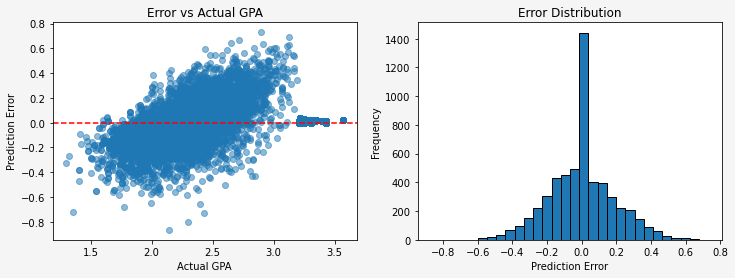

In [53]:
# Analyze error distribution
errors = y_test - y_pred

# Check for systematic biases
plt.figure(figsize=(12, 4), facecolor="whitesmoke")
plt.subplot(1, 2, 1)
plt.scatter(y_test, errors, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual GPA')
plt.ylabel('Prediction Error')
plt.title('Error vs Actual GPA')

plt.subplot(1, 2, 2)
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()

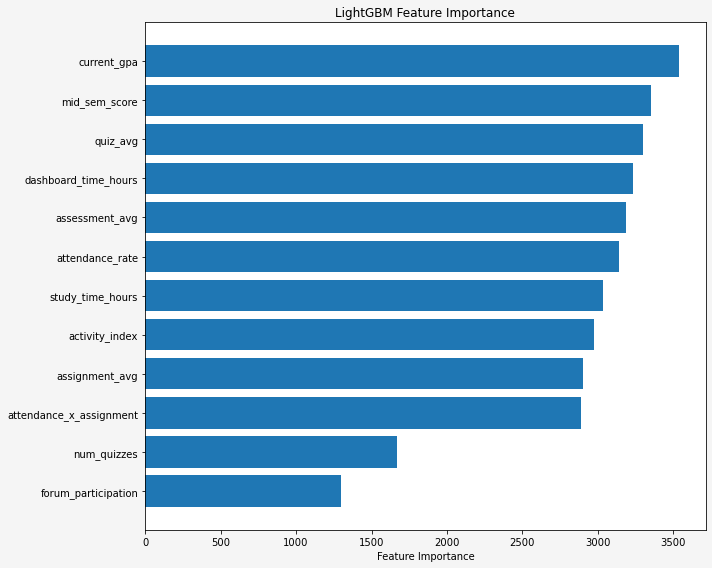

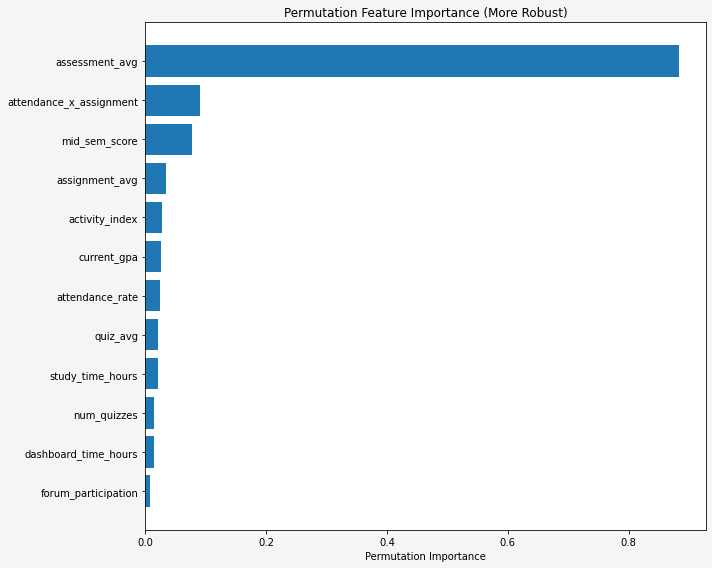

In [55]:
from sklearn.inspection import permutation_importance

# Feature importance from LightGBM
feature_importance = final_model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 8), facecolor="whitesmoke")
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# Permutation importance for more robust analysis
perm_importance = permutation_importance(final_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_perm_idx = np.argsort(perm_importance.importances_mean)

plt.figure(figsize=(10, 8), facecolor="whitesmoke")
plt.barh(range(len(sorted_perm_idx)), perm_importance.importances_mean[sorted_perm_idx])
plt.yticks(range(len(sorted_perm_idx)), [feature_names[i] for i in sorted_perm_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance (More Robust)')
plt.tight_layout()
plt.show()

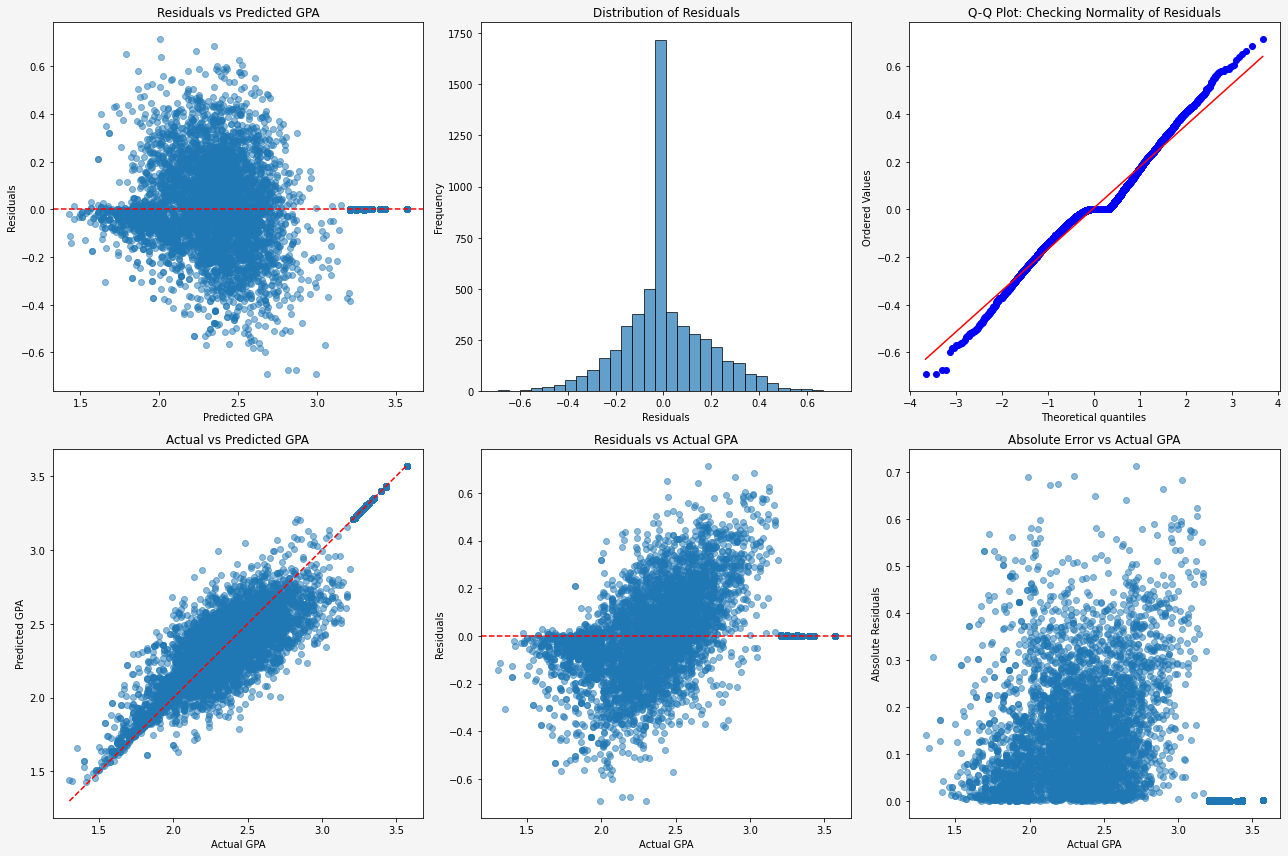

In [58]:
# Calculate residuals
y_pred = final_model.predict(X_test)
residuals = y_test - y_pred

# Comprehensive residual plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12), facecolor="whitesmoke")

# 1. Residuals vs Predicted values
axes[0,0].scatter(y_pred, residuals, alpha=0.5)
axes[0,0].axhline(y=0, color='red', linestyle='--')
axes[0,0].set_xlabel('Predicted GPA')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Predicted GPA')

# 2. Residuals distribution
axes[0,1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0,1].set_xlabel('Residuals')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Residuals')

# 3. Q-Q plot for normality
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0,2])
axes[0,2].set_title('Q-Q Plot: Checking Normality of Residuals')

# 4. Actual vs Predicted
axes[1,0].scatter(y_test, y_pred, alpha=0.5)
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
axes[1,0].plot([min_val, max_val], [min_val, max_val], 'red', linestyle='--')
axes[1,0].set_xlabel('Actual GPA')
axes[1,0].set_ylabel('Predicted GPA')
axes[1,0].set_title('Actual vs Predicted GPA')

# 5. Residuals by actual GPA
axes[1,1].scatter(y_test, residuals, alpha=0.5)
axes[1,1].axhline(y=0, color='red', linestyle='--')
axes[1,1].set_xlabel('Actual GPA')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residuals vs Actual GPA')

# 6. Absolute residuals by GPA range
abs_residuals = np.abs(residuals)
axes[1,2].scatter(y_test, abs_residuals, alpha=0.5)
axes[1,2].set_xlabel('Actual GPA')
axes[1,2].set_ylabel('Absolute Residuals')
axes[1,2].set_title('Absolute Error vs Actual GPA')

plt.tight_layout()
plt.show()

Performance by GPA Range:
  GPA_Range      RMSE      MAPE  Count
0      <2.0  0.142905  4.920731   1040
1   2.0-2.5  0.185503  6.487712   2283
2   2.5-3.0  0.229206  6.945745   1227
3   3.0-3.5  0.095153  0.686750   1004
4      3.5+  0.001629  0.045623     27


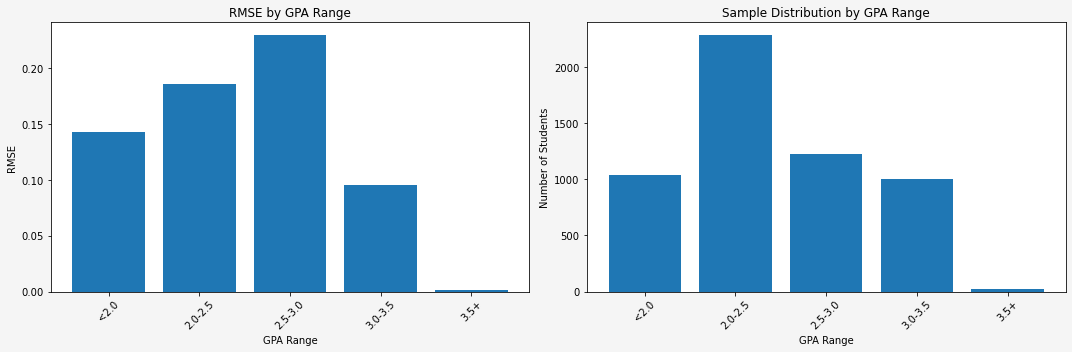

In [60]:
# Analyze performance across different GPA ranges
gpa_bins = [0, 2.0, 2.5, 3.0, 3.5, 4.0]
gpa_labels = ['<2.0', '2.0-2.5', '2.5-3.0', '3.0-3.5', '3.5+']

if hasattr(y_test, 'iloc'):
    gpa_groups = pd.cut(y_test, bins=gpa_bins, labels=gpa_labels)
else:
    y_test_series = pd.Series(y_test)
    gpa_groups = pd.cut(y_test_series, bins=gpa_bins, labels=gpa_labels)

# Calculate metrics by GPA range
range_metrics = []
for gpa_range in gpa_labels:
    mask = gpa_groups == gpa_range
    if mask.sum() > 0:  # Check if there are samples in this range
        range_rmse = np.sqrt(np.mean(residuals[mask]**2))
        range_mape = np.mean(np.abs(residuals[mask] / y_test[mask])) * 100
        range_count = mask.sum()
        range_metrics.append({
            'GPA_Range': gpa_range,
            'RMSE': range_rmse,
            'MAPE': range_mape,
            'Count': range_count
        })

metrics_df = pd.DataFrame(range_metrics)
print("Performance by GPA Range:")
print(metrics_df)

# Plot performance by GPA range
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), facecolor="whitesmoke")

# RMSE by GPA range
ax1.bar(metrics_df['GPA_Range'], metrics_df['RMSE'])
ax1.set_xlabel('GPA Range')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE by GPA Range')
ax1.tick_params(axis='x', rotation=45)

# Sample count by GPA range
ax2.bar(metrics_df['GPA_Range'], metrics_df['Count'])
ax2.set_xlabel('GPA Range')
ax2.set_ylabel('Number of Students')
ax2.set_title('Sample Distribution by GPA Range')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [61]:
import joblib

#save lightgbm model
joblib.dump(best_lgbm, "Lightgbm_regressor_model.kpl")

print("✅ Model saved successfully!")

✅ Model saved successfully!


BUILDING THE CLASSIFIER

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode target labels
label_encoder = LabelEncoder()
y_class = label_encoder.fit_transform(df["risk_category"])  # 0=At risk, 1=Average, 2=Excellent

# Reuse same features X from before
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42)


In [67]:
# For multi-class classification
classifier = LGBMClassifier(
    objective='multiclass',
    random_state=42, 
    n_jobs=-1
)

# Hyperparameter tuning for classification
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [200, 300, 500],
    'max_depth': [-1, 10, 15],
    'class_weight': [None, 'balanced']  # Important for imbalanced data!
}

grid_search = GridSearchCV(
    classifier, param_grid, cv=5, 
    scoring='f1_weighted',  # Use F1 for imbalanced data
    n_jobs=-1, verbose=1
)

grid_search.fit(X_train_c, y_train_c)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2537
[LightGBM] [Info] Number of data points in the train set: 22320, number of used features: 12
[LightGBM] [Info] Start training from score -1.724704
[LightGBM] [Info] Start training from score -0.443896
[LightGBM] [Info] Start training from score -1.713455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

GridSearchCV(cv=5,
             estimator=LGBMClassifier(n_jobs=-1, objective='multiclass',
                                      random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [-1, 10, 15],
                         'n_estimators': [200, 300, 500],
                         'num_leaves': [31, 50, 70]},
             scoring='f1_weighted', verbose=1)

In [69]:
# Get the best model and parameters
print("=== GRID SEARCH RESULTS ===")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

# Check the best estimator
best_classifier = grid_search.best_estimator_
print(f"Best estimator: {best_classifier}")

=== GRID SEARCH RESULTS ===
Best cross-validation score: 0.9522
Best parameters: {'class_weight': None, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 70}
Best estimator: LGBMClassifier(n_estimators=500, n_jobs=-1, num_leaves=70,
               objective='multiclass', random_state=42)


Model Evaluation

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on test set
y_pred = best_classifier.predict(X_test_c)
y_pred_proba = best_classifier.predict_proba(X_test_c)

print("\n=== TEST SET PERFORMANCE ===")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_c, y_pred))


=== TEST SET PERFORMANCE ===
Accuracy: 0.9579

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1022
           1       0.97      0.97      0.97      3582
           2       1.00      1.00      1.00       977

    accuracy                           0.96      5581
   macro avg       0.95      0.95      0.95      5581
weighted avg       0.96      0.96      0.96      5581




=== TOP 10 PARAMETER COMBINATIONS ===
 mean_test_score  std_test_score                                                                                                params
        0.952221        0.002737  {'class_weight': None, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 70}
        0.951483        0.003721 {'class_weight': None, 'learning_rate': 0.15, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 50}
        0.951111        0.003085  {'class_weight': None, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 70}
        0.951036        0.003378  {'class_weight': None, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 500, 'num_leaves': 70}
        0.950936        0.002073 {'class_weight': None, 'learning_rate': 0.15, 'max_depth': 15, 'n_estimators': 500, 'num_leaves': 70}
        0.950824        0.003710 {'class_weight': None, 'learning_rate': 0.15, 'max_depth': 15, 'n_estimators': 500, 'num_leaves': 50}
        0.950599

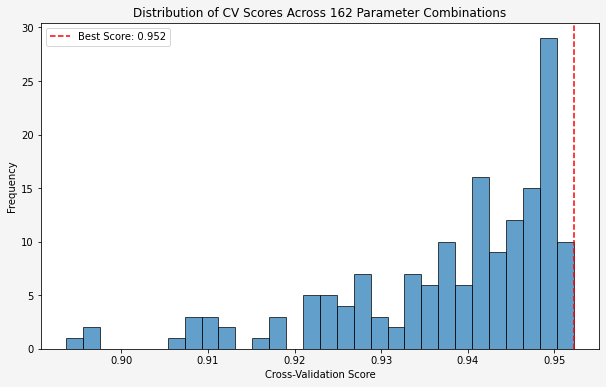

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert results to DataFrame for analysis
cv_results = pd.DataFrame(grid_search.cv_results_)

# Show top 10 performing parameter combinations
print("\n=== TOP 10 PARAMETER COMBINATIONS ===")
top_10 = cv_results.nlargest(10, 'mean_test_score')[
    ['mean_test_score', 'std_test_score', 'params']
]
print(top_10.to_string(index=False))

# Plot performance distribution
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
plt.hist(cv_results['mean_test_score'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Cross-Validation Score')
plt.ylabel('Frequency')
plt.title('Distribution of CV Scores Across 162 Parameter Combinations')
plt.axvline(x=grid_search.best_score_, color='red', linestyle='--', 
           label=f'Best Score: {grid_search.best_score_:.3f}')
plt.legend()
plt.show()


=== TOP 10 MOST IMPORTANT FEATURES ===
                    feature  importance
4             mid_sem_score        8352
9            assessment_avg        8350
8               current_gpa        8153
0           attendance_rate        7724
7      dashboard_time_hours        7359
2                  quiz_avg        7334
6          study_time_hours        7166
10           activity_index        7020
11  attendance_x_assignment        6721
3            assignment_avg        6653


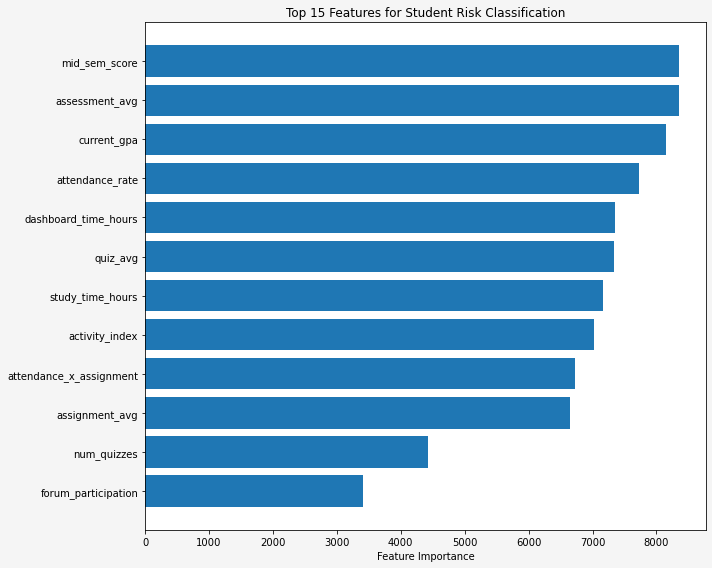

In [77]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_c.columns if hasattr(X_train_c, 'columns') 
               else [f'Feature_{i}' for i in range(X_train_cat.shape[1])],
    'importance': best_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== TOP 10 MOST IMPORTANT FEATURES ===")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8), facecolor="whitesmoke")
plt.barh(feature_importance['feature'].head(15)[::-1], 
         feature_importance['importance'].head(15)[::-1])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features for Student Risk Classification')
plt.tight_layout()
plt.show()

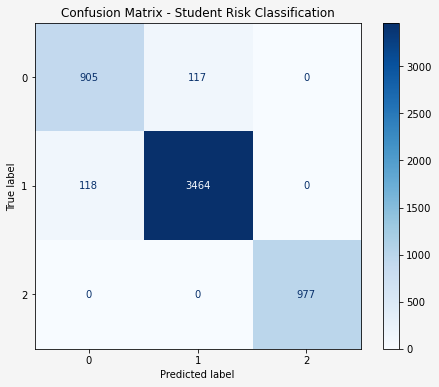


=== BUSINESS-ORIENTED METRICS ===
Precision: Of students predicted in this category, how many are correct
Recall: Of actual students in this category, how many we successfully identify
   Class  Precision    Recall  F1-Score  Support
0      0   0.884653  0.885519  0.885086     1022
1      1   0.967328  0.967058  0.967193     3582
2      2   1.000000  1.000000  1.000000      977


In [81]:
# Confusion matrix with business interpretation
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test_c, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=best_classifier.classes_)
fig, ax = plt.subplots(figsize=(8, 6), facecolor="whitesmoke")
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix - Student Risk Classification')
plt.show()

# Calculate business metrics
def calculate_business_metrics(y_true, y_pred):
    from sklearn.metrics import precision_recall_fscore_support
    
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, 
                                                                     labels=best_classifier.classes_)
    
    metrics_df = pd.DataFrame({
        'Class': best_classifier.classes_,
        'Precision': precision,
        'Recall': recall, 
        'F1-Score': f1,
        'Support': support
    })
    
    print("\n=== BUSINESS-ORIENTED METRICS ===")
    print("Precision: Of students predicted in this category, how many are correct")
    print("Recall: Of actual students in this category, how many we successfully identify")
    print(metrics_df)
    
    return metrics_df

business_metrics = calculate_business_metrics(y_test_c, y_pred)


=== CLASS DISTRIBUTION ===
Training set:
1    14319
2     4023
0     3978
dtype: int64

Test set:
1    3582
0    1022
2     977
dtype: int64


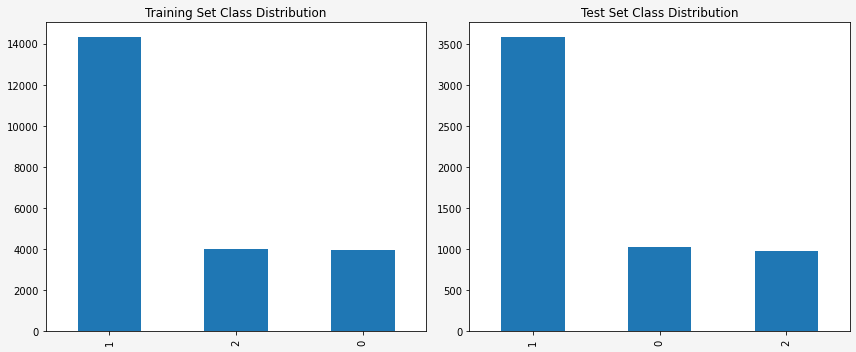

In [84]:
# Analyze class distribution
class_distribution = pd.Series(y_train_c).value_counts()
class_distribution_test = pd.Series(y_test_c).value_counts()

print("\n=== CLASS DISTRIBUTION ===")
print("Training set:")
print(class_distribution)
print("\nTest set:")
print(class_distribution_test)

# Plot class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), facecolor="whitesmoke")
class_distribution.plot(kind='bar', ax=ax1, title='Training Set Class Distribution')
class_distribution_test.plot(kind='bar', ax=ax2, title='Test Set Class Distribution')
plt.tight_layout()
plt.show()

In [85]:
#saving the model
joblib.dump(lgbm_clf, "lightgbm_risk_classifier.pkl")
print("✅ Classification model saved successfully!")

✅ Classification model saved successfully!
